# Setup
---
<br>
<br>
<br>
<br>
<br>


In [3]:
def setup(basedir=None):
    if basedir==None:
            basedir = "/media/michaelkatsoulis/Data raw/Datasets/KITTI_cvlibs/"
    date = '2011_09_26'
    drive = "0001"
    return pykitti.raw(basedir, date, drive)
        

In [40]:
import cv2
import pykitti
import matplotlib.pylab as plt
import numpy as np
import time

from jupyterthemes import jtplot
jtplot.style()

%matplotlib notebook

im_fig_size=(15,5)

data = setup()

img_frame = 100
#     print(data.calib)
cam2_image, cam3_image = data.get_rgb(img_frame)
# imgL = cv2.imread(np.array(cam2_image), cv2.COLOR_RGB2BGR)
# imgR = cv2.cvtColor(np.array(cam3_image), cv2.COLOR_RGB2BGR)

imgL = np.array(cam2_image)
imgR = np.array(cam3_image)

lidar_data = data.get_velo(img_frame)

In [39]:
# type(cam2_image)

PIL.Image.Image

Text(0.5, 1.0, 'Lidar plot coloured by depth')

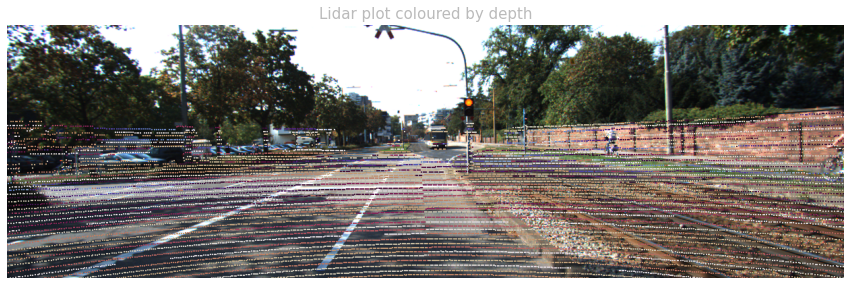

In [50]:
def pointcloud_to_image(pointcloud,img_height,img_width,Tr,P,useDepth=True):
    #     Trimming pointcloud for speedup
    pointcloud = pointcloud[pointcloud[:, 0] >
                            0]  #Everything in front of camera

    xyz = pointcloud[:, :3]
    reflectance = pointcloud[:, 3]

    #     making the pointcloud homogenous
    xyz = np.hstack((xyz, np.ones((xyz.shape[0], 1))))
    #     xyz now [ X, Y, Z, 1]

    #     transforming lidar into camera frame
    cam_xyz = Tr.dot(xyz.T).T
    lidar_depth = cam_xyz[:, 2].copy()  #Everything in front of camera
    cam_xyz = cam_xyz / cam_xyz[:, 2].reshape((-1, 1))

    img_xyz = P.dot(cam_xyz.T).T

    pixel_coords = img_xyz.round(0).astype(int)
    indicies = np.where((pixel_coords[:, 0] >= 0)
                        & (pixel_coords[:, 1] >= 0)
                        & (pixel_coords[:, 0] < imgL.shape[1])
                        & (pixel_coords[:, 1] < imgL.shape[0]))

    pixel_coords = pixel_coords[indicies]
    pixel_coords.max(axis=0)
    render = np.zeros((img_height, img_width))

    for j, (u, v) in enumerate(pixel_coords[:, :2]):
        if useDepth: render[v, u] = lidar_depth[j]
        else:
            render[v, u] = (reflectance[j] * 255).astype(int)

    return render

render_lidar = pointcloud_to_image(lidar_data, imgL.shape[0], imgL.shape[1], data.calib.T_cam2_velo, data.calib.P_rect_20)


%matplotlib inline

fig_l, ax_l = plt.subplots(1,1, figsize=im_fig_size)
kernel2=np.ones((2,2), np.uint8)
kernel3=np.ones((3,3), np.uint8)
dst = (255*(render_lidar.copy())/render_lidar.max()).astype(np.uint8)
dst = cv2.dilate(dst, kernel2, iterations=1)
inds = np.where(dst>0)
dst = cv2.applyColorMap(dst, cv2.COLORMAP_TWILIGHT)

im_gray3 = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
im_gray3 = cv2.cvtColor(im_gray3, cv2.COLOR_GRAY2BGR)

# img_dist = im_gray3.copy()
img_dist = imgL.copy()
img_dist[inds] = dst[inds]

# ax_l[1].imshow(cv2.dilate(render_reflectance.copy(), kernel, iterations=1))
# ax_l[1].imshow(img_ref)
ax_l.imshow(img_dist)
ax_l.axis('off')
ax_l.set_title("Lidar plot coloured by depth",  fontsize=im_fig_size[0])

# LiDAR to Triangular meshes
---
<br>
<br>
<br>
<br>
<br>


In [66]:
def pointcloud_to_img_frame(pointcloud, img_height, img_width, Tr, P, useDepth=True):
    #     Trimming pointcloud for speedup
    pointcloud = pointcloud[pointcloud[:, 0] > 0].copy()  #Everything in front of camera

    xyz = pointcloud[:, :3]
    reflectance = pointcloud[:, 3]

    #     making the pointcloud homogenous
    xyz = np.hstack((xyz, np.ones((xyz.shape[0], 1))))
    #     xyz now [ X, Y, Z, 1]

    #     transforming lidar into camera frame
    cam_xyz = Tr.dot(xyz.T).T
#     lidar_depth = cam_xyz[:, 2].copy()  #Everything in front of camera
    cam_xyz = cam_xyz / cam_xyz[:, 2].reshape((-1, 1))

    img_xyz = P.dot(cam_xyz.T).T # image frame
    pixel_coords = img_xyz.round(0).astype(int)
    indicies = np.where((pixel_coords[:, 0] >= 0)
                        & (pixel_coords[:, 1] >= 0)
                        & (pixel_coords[:, 0] < imgL.shape[1])
                        & (pixel_coords[:, 1] < imgL.shape[0]))

#     pixel_coords = pixel_coords[indicies]
#     pixel_coords.max(axis=0)
#     render = np.zeros((img_height, img_width))

#     for j, (u, v) in enumerate(pixel_coords[:, :2]):
#         if useDepth: render[v, u] = lidar_depth[j]
#         else:
#             render[v, u] = (reflectance[j] * 255).astype(int)

    return xyz[indicies]

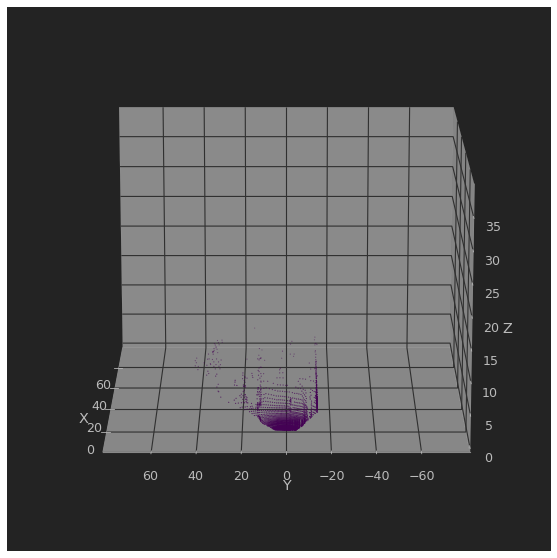

In [93]:
cropped_lidar = pointcloud_to_img_frame(lidar_data, imgL.shape[0], imgL.shape[1], data.calib.T_cam2_velo, data.calib.P_rect_20)



# %matplotlib notebook

fig_lc= plt.figure(figsize=[20,10])
cropped_lidar_subsampled = cropped_lidar[::10]
ax_lc = fig_lc.add_subplot(111, projection='3d')
ax_lc.scatter3D(cropped_lidar_subsampled[:,0], cropped_lidar_subsampled[:,1], cropped_lidar_subsampled[:,2],s=1, c=cropped_lidar_subsampled[:,3])
ax_lc.set_xlabel("X")
ax_lc.set_ylabel("Y")
ax_lc.set_zlabel("Z")


ax_lims = [cropped_lidar_subsampled.min(),cropped_lidar_subsampled.max()]
ax_lc.set_xlim(ax_lims)
ax_lc.set_ylim([-cropped_lidar_subsampled.max(),cropped_lidar_subsampled.max()])
ax_lc.set_zlim([0,cropped_lidar_subsampled.max()/2])

ax_lc.view_init(elev=15., azim=180)

In [96]:
import DelaunayTriangulate as dt

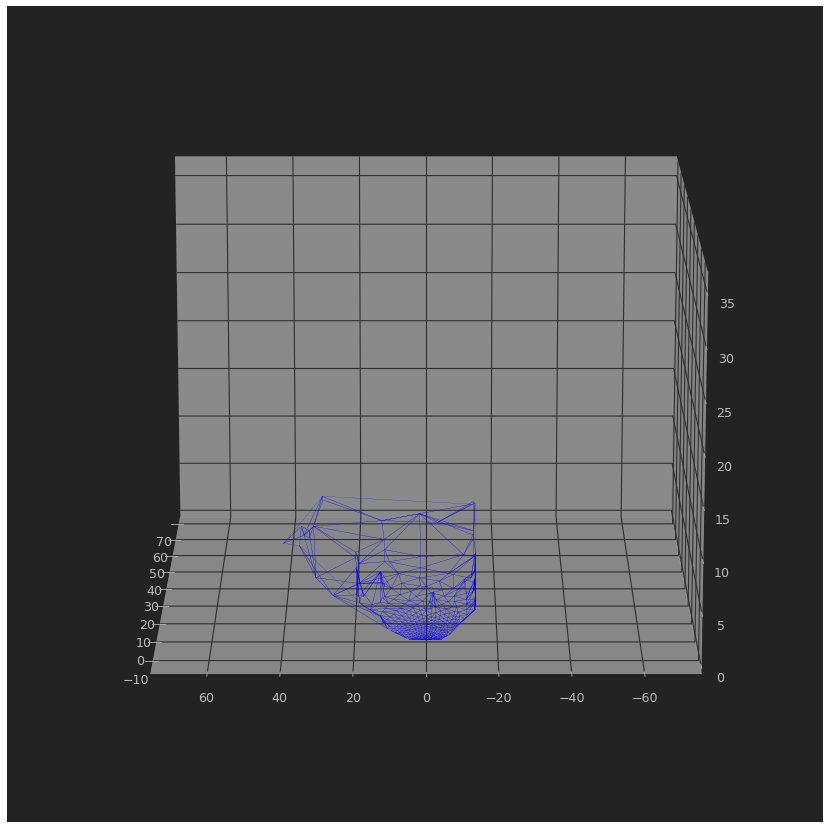

In [112]:
cropped_lidar_subsampled = cropped_lidar[::50]

cropped_triangles = dt.Delaunay(cropped_lidar_subsampled[:,:2])

tri_num = cropped_triangles.simplices.max()//2
tmp = cropped_lidar_subsampled[cropped_triangles.simplices[tri_num]]



%matplotlib inline


fig = plt.figure(figsize=[20,15])
ax = fig.add_subplot(1,1,1,projection='3d')
# Plot triangles
ax.plot_trisurf(cropped_lidar_subsampled[:,0], cropped_lidar_subsampled[:,1], cropped_lidar_subsampled[:,2],color='none', edgecolor='blue',triangles=cropped_triangles.simplices)
# ax.plot_trisurf(tmp[:,0], tmp[:,1], tmp[:,2], color='red')#,triangles=[0,1,2])


ax_lims = [cropped_lidar_subsampled.min(),cropped_lidar_subsampled.max()]
ax.set_xlim(ax_lims)
ax.set_ylim([-cropped_lidar_subsampled.max(),cropped_lidar_subsampled.max()])
ax.set_zlim([0,cropped_lidar_subsampled.max()/2])

ax.view_init(elev=15., azim=180)

# Exploring Geometric Error in Sampling
---
<br>
<br>
<br>
<br>
<br>


## Error Metrics
<br>
<br>
<br>


### Euclidean distance at center of triangles
<br>
<br>
<br>


### Hausdroff Error
<br>
<br>


See: http://www.cmap.polytechnique.fr/~peyre/cours/x2005signal/mesh_mesh.pdf
<br>
<br>


## Sampling the mesh
<br>
<br>
<br>
